In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

### Run at startup

          tic_id          RA       Dec    Tmag         Epoc   Period  \
15380  229455001  294.100188  65.17425  8.9461  1701.935394  22.3414   

       Duration  Transit_Depth  Sectors  star_rad  ...    teff    logg  \
15380  0.088249          490.0      2.0   1.13948  ...  6179.0  4.3969   

             SN  Qingress  disp_E  disp_J  disp_N  disp_S  disp_B     TIC ID  
15380  12.10729   0.24859       0       4       1       0       0  229455001  

[1 rows x 21 columns]
Time range:  1683.36403253 - 2035.11548111


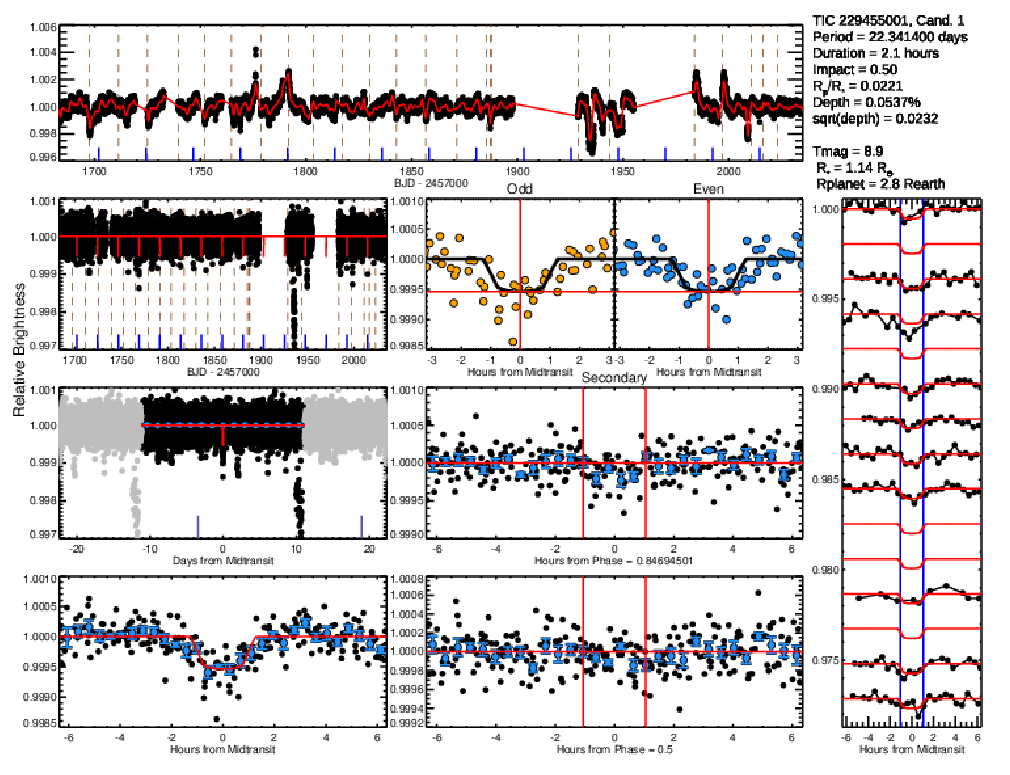

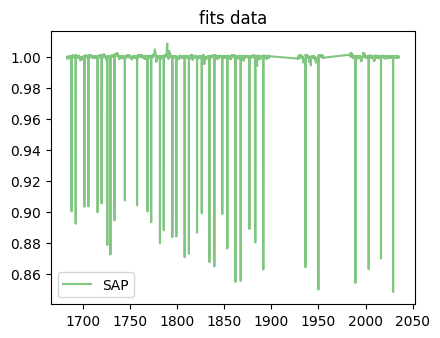

In [93]:
plot_all(229455001,
         rpt_only=True,
#          large=True,
#          bkspace=5.0,
#          abs_xlim='3p',
#          abs_offset=4,
#          abs_xlim=(1830.5, 1840),
#          abs_ylim='3%',
#          abs_ylim=(0.9, 1.1),
#          item_no=1,
         lc='/mnt/tess/lc/tess2020262000000-s0026-0000000229455001-1111-cr_llc.fits.gz',
         raw_only=True,
        )

In [2]:
from astropy.io import fits
from astronet.preprocess import generate_input_records
from astronet.preprocess import preprocess
from light_curve_util import keplersplinev2
from light_curve_util import tess_io
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


tce_tables = {}

tce_files = [
    '/mnt/tess/astronet/tces-v7-train.csv',
#     '/mnt/tess/astronet/tces-v12-all.csv',
#     '/mnt/tess/astronet/tces-tmp-all.csv',
    '/mnt/tess/astronet/tces-toi.csv',
    '/mnt/tess/astronet/tces-s33_cam1_sample.csv',
    '/mnt/tess/astronet/tces-s33_cam2ccd14_sample.csv',
]

tess_data_dir = f'/mnt/tess/lc'
reports_dir = f'/mnt/tess/rpt/png'


def get_tce(tic, item_no):
    for f in tce_files:
        if f not in tce_tables:
            tce_tables[f] = pd.read_csv(f, header=0)
        tce_table = tce_tables[f]
        tce = tce_table[tce_table.tic_id == tic]
        if not len(tce):
            continue
        if len(tce) > 1:
            tce = tce[tce.index == tce.index.values[item_no]]
            if 'Source' in tce:
                print('Source:', 'BLS' if tce.Source.values.item() == 2 else 'TEV')
            else:
                print('WARNING: duplicate TCE record')
        return tce, f
    raise ValueError(f'no TCE data for {tic}')


def plot_rpt(tic, dpi):
  try:
    try:
      im = plt.imread(f'{reports_dir}/TIC{tic}.png')
    except FileNotFoundError:
      im = plt.imread(f'{reports_dir}/{tic}.png')
    plt.figure(figsize=(16, 10), dpi=dpi)
    plt.axis('off')
    _ = plt.imshow(im)
  except FileNotFoundError:
      print('-- no report file --')


def plot_all(tic,
             large=False,
             dpi=100,
             bkspace=None,
             abs_xlim=None,
             abs_offset=0,
             abs_ylim=None,
             rpt_only=False,
             item_no=0,
             lc=None,
             raw_only=False):
    if rpt_only:
      plot_rpt(tic, dpi)
      if not raw_only:
        return
        
    b = plt.get_cmap('tab20')(0)
    b2 = plt.get_cmap('tab20')(1)
    o = plt.get_cmap('tab20')(2)
    o2 = plt.get_cmap('tab20')(3)
    g = plt.get_cmap('tab20')(4)
    r = plt.get_cmap('tab20')(6)
    n = plt.get_cmap('tab20')(8)
    k = plt.get_cmap('tab20')(14)

    plotrows = 14
    plotcols = 3
    
    if large:
        fsize = (16, 9)
    else:
        fsize = (16, 4 * (plotrows + 1))
        plt.figure(figsize=fsize, dpi=dpi)
    
    tce, tces_file = get_tce(tic, item_no)
    period = tce.Period.values.item()
    epoc = tce.Epoc.values.item()
    duration = tce.Duration.values.item()

    print(tce)
    
    def config_abs_plot(title):
        plt.legend()
        plt.title(title)
        if abs_xlim:
            if abs_xlim == '3p':
                minx = min(td) + abs_offset * period
                maxx = minx + 3.5 * period
                plt.xlim(minx, maxx)
            else:
                plt.xlim(*abs_xlim)
        if abs_ylim:
            if abs_ylim == '3%':
                miny = np.percentile(fs[~np.isnan(fs)], 3)
                maxy = np.percentile(fs[~np.isnan(fs)], 97)
                plt.ylim(miny, maxy)
            else:
                plt.ylim(*abs_ylim)
                
    nplotted = 0
    def splt(c=1):
        nonlocal nplotted
        if large:
            plt.figure(figsize=fsize, dpi=dpi)
        else:
            plt.subplot(plotrows, plotcols // c, (nplotted // c) + 1)
        nplotted += c
    
    
    if lc is None:
      file_names = tess_io.tess_filenames(tic, tess_data_dir)
    else:
      file_names = lc
    f = fits.open(file_names)

    td = f[1].data["TIME"]
    fs = f[1].data["SAP_FLUX"]
    
    splt()
    plt.plot(td, fs, '-', alpha=0.6, color=g, label='SAP')
    config_abs_plot('fits data')
    
    
    if raw_only:
      print('Time range: ', min(td), '-', max(td))
      return
    
    
    splt()
    ut, uf, _ = preprocess.read_and_process_light_curve(tic, tess_data_dir, 'SAP_FLUX')

    input_mask = preprocess.get_spline_mask(ut, period, epoc, duration)
    sf, mdata = keplersplinev2.choosekeplersplinev2(
        ut, uf, input_mask=input_mask, return_metadata=True,
        fixed_bkspace=bkspace,
    )

    plt.plot(ut, uf, '-', alpha=0.6, color=g, label='SAP')
    plt.plot(ut[input_mask], sf[input_mask], 'x', markersize=3, color=k, label='spline (OOT)')
    plt.plot(ut[~input_mask], sf[~input_mask], 'o', markersize=3, color=o, label='spline')
    config_abs_plot(f'raw | bkspace: {mdata.bkspace}')    
    
    ut, nf, fm = preprocess.detrend_and_filter(
        tic, ut, uf, period, epoc, duration, bkspace)
    sft, sff, sfn, sftm = preprocess.phase_fold_and_sort_light_curve(
        ut, nf, input_mask, period, epoc)

    splt()
    plt.plot(sft, sff, 'o', markersize=3, alpha=0.6, c=o, label='spline')
    sff_filtered = np.where((sff > 1.5) | (sff < -0.5), 0, sff)
    if len(sff_filtered):
        mask = np.where(sftm, 1, min(sff_filtered))
        plt.plot(sft, mask, '-', markersize=1, alpha=0.6, c=r, label='OOT')
        title = f'phase folded ({int(max(sfn) + 1)} folds) / filtered'
    else:
        if len(sfn):
            title = f'phase folded ({int(max(sfn) + 1)} folds) | WARNING: filtering removed all data'
        else:
            title = f'phase folded | WARNING: filtering removed all data'
    plt.legend()
    plt.title(title)


    generate_input_records.FLAGS = generate_input_records.parser.parse_args([
      '--tess_data_dir', '/mnt/tess/lc',
      '--output_dir', '/dev/null',
      '--input_tce_csv_file', tces_file,
    ])


    row = list(tce.iterrows())[0][1]

    ex = generate_input_records._process_tce(row, bkspace)
    
    
    def plot_w_scatter(view, std, title, mask=None):
        splt()
        view = np.array(ex.features.feature[view].float_list.value)
        std = np.array(ex.features.feature[std].float_list.value)
        plt.plot(std, color=o)
        plt.plot(view, color=n)
        if mask:
            plt.plot(
                -np.array(ex.features.feature[mask].float_list.value), color=r, alpha=0.5, linestyle='--')
        plt.title(title)
        
    def plot_norm(view, title):
        splt()
        plt.plot(ex.features.feature[view].float_list.value, color=n)
        plt.ylim(-1, 1)
        plt.title(title)    
        
        
    def plot_segments(view, tag, num_chans=14, min_chans=None, max_chans=None):
        splt(c=3)
        img = ex.features.feature[view].float_list.value
        img = np.reshape(img, (-1, num_chans))[:, min_chans:max_chans]
        n_transits = img.shape[1] // 2
        for i in range(n_transits):
            view = img[:, 2 * i]
            mask = img[:, 2 * i + 1] > 0
            plt.plot(np.where(mask, view, np.nan), marker='.')
        plt.title(f'{n_transits} sample segments, densest first, ties broken at random {tag}')
        
    plot_w_scatter('global_view', 'global_std', 'global')
    plot_w_scatter('global_view_0.3', 'global_std_0.3', 'global @ 0.3')
    plot_w_scatter('global_view_5.0', 'global_std_5.0', 'global @ 5.0')

    sec_phase = ex.features.feature['secondary_phase'].float_list.value[0]
    loc_scale = ex.features.feature['local_scale'].float_list.value[0]
    sec_scale = ex.features.feature['secondary_scale'].float_list.value[0]
    plot_w_scatter('global_view', 'global_std', 'global', 'global_transit_mask')
    plot_w_scatter('local_view', 'local_std', f'local / {loc_scale:0.3}')
    plot_w_scatter('secondary_view', 'secondary_std', f'secondary ({sec_phase:0.2}) / {sec_scale:0.5}')
    plot_w_scatter('local_view_half_period', 'local_view_half_period_std', 'local half period')
    plot_w_scatter('local_view_even', 'local_std_even', 'local even')
    plot_w_scatter('local_view_odd', 'local_std_odd', 'local odd')
    plot_segments('sample_segments_local_view', 'odd', num_chans=16, min_chans=0, max_chans=8)
    plot_segments('sample_segments_local_view', 'even', num_chans=16, min_chans=8, max_chans=16)

    sec_phase = ex.features.feature['secondary_phase_0.3'].float_list.value[0]
    loc_scale = ex.features.feature['local_scale_0.3'].float_list.value[0]
    sec_scale = ex.features.feature['secondary_scale_0.3'].float_list.value[0]
    plot_w_scatter('global_view_0.3', 'global_std_0.3', 'global_0.3', 'global_transit_mask_0.3')
    plot_w_scatter('local_view_0.3', 'local_std_0.3', f'local @0.3 / {loc_scale:0.3}')
    plot_w_scatter('secondary_view_0.3', 'secondary_std_0.3', f'secondary @0.3 ({sec_phase:0.2}) / {sec_scale:0.5}')
    plot_w_scatter('local_view_half_period_0.3', 'local_view_half_period_std_0.3', 'local half period @0.3')
    plot_w_scatter('local_view_even_0.3', 'local_std_even_0.3', 'local even @0.3')
    plot_w_scatter('local_view_odd_0.3', 'local_std_odd_0.3', 'local odd @0.3')
    plot_segments('sample_segments_local_view_0.3', 'odd @0.3', num_chans=16, min_chans=0, max_chans=8)
    plot_segments('sample_segments_local_view_0.3', 'even @0.3', num_chans=16, min_chans=8, max_chans=16)
    
    sec_phase = ex.features.feature['secondary_phase_5.0'].float_list.value[0]
    loc_scale = ex.features.feature['local_scale_5.0'].float_list.value[0]
    sec_scale = ex.features.feature['secondary_scale_5.0'].float_list.value[0]
    plot_w_scatter('global_view_5.0', 'global_std_5.0', 'global_5.0', 'global_transit_mask_5.0')
    plot_w_scatter('local_view_5.0', 'local_std_5.0', f'local @5.0 / {loc_scale:0.3}')
    plot_w_scatter('secondary_view_5.0', 'secondary_std_5.0', f'secondary @5.0 ({sec_phase:0.2}) / {sec_scale:0.5}')
    plot_w_scatter('local_view_half_period_5.0', 'local_view_half_period_std_5.0', 'local half period @5.0')
    plot_w_scatter('local_view_even_5.0', 'local_std_even_5.0', 'local even @5.0')
    plot_w_scatter('local_view_odd_5.0', 'local_std_odd_5.0', 'local odd @5.0')
    plot_segments('sample_segments_local_view_5.0', 'odd @5.0', num_chans=16, min_chans=0, max_chans=8)
    plot_segments('sample_segments_local_view_5.0', 'even @5.0', num_chans=16, min_chans=8, max_chans=16)

    plot_rpt(tic, dpi)